In [103]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
output_notebook()
%matplotlib inline 
def get_product_agg(cols):
    df_train = pd.read_csv('../input/train.csv', usecols = ['Semana', 'Producto_ID'] + cols,
                           dtype  = {'Semana': 'int32',
                                     'Producto_ID':'int32',
                                     'Venta_hoy':'float32',
                                     'Venta_uni_hoy': 'int32',
                                     'Dev_uni_proxima':'int32',
                                     'Dev_proxima':'float32',
                                     'Demanda_uni_equil':'int32'})
    agg  = df_train.groupby(['Semana', 'Producto_ID'], as_index=False).agg(['count','sum', 'min', 'max','median','mean'])
    agg.columns  =  ['_'.join(col).strip() for col in agg.columns.values]
    del(df_train)
    return agg

Loading BokehJS ...

### a simple product aggregate. Kaggle computing power allows us to only calculate 1-2 fields at a time.

In [104]:
agg1 = get_product_agg(['Demanda_uni_equil','Dev_uni_proxima'])

In [105]:
agg1.shape

(10908, 12)

In [106]:
agg1.head()


Dev_uni_proxima_count  Dev_uni_proxima_sum  \
Semana Producto_ID                                               
3      41                               8                  104   
       53                               6                    0   
       72                           17825                 1979   
       73                           31495                 3015   
       100                             22                  168   

                    Dev_uni_proxima_min  Dev_uni_proxima_max  \
Semana Producto_ID                                             
3      41                             0                   90   
       53                             0                    0   
       72                             0                   72   
       73                             0                   26   
       100                            0                   63   

                    Dev_uni_proxima_median  Dev_uni_proxima_mean  \
Semana Producto_ID                                                 
3      41                              0.0             13.000000   
       53                              0.0              0.000000   
       72                              0.0              0.111024   
       73                              0.0              0.095729   
       100                             0.0              7.636364   

                    Demanda_uni_equil_count  Demanda_uni_equil_sum  \
Semana Producto_ID                                                   
3      41                                 8                   3661   
       53                                 6                   2924   
       72                             17825                  86135   
       73                             31495                 101456   
       100                               22                    170   

                    Demanda_uni_equil_min  Demanda_uni_equil_max  \
Semana Producto_ID                                                 
3      41                               0                   2064   
       53                             116                   1289   
       72                               0                    600   
       73                               0                    287   
       100                              0                     40   

                    Demanda_uni_equil_median  Demanda_uni_equil_mean  
Semana Producto_ID                                                    
3      41                              115.0              457.625000  
       53                              417.5              487.333333  
       72                                4.0                4.832258  
       73                                2.0                3.221337  
       100                               3.5                7.727273

In [107]:
agg2 = get_product_agg(['Venta_uni_hoy'])
agg = agg1.join(agg2)

Let's preprocess products a little bit. I borrowed some of the preprocessing from [here](https://www.kaggle.com/lyytinen/grupo-bimbo-inventory-demand/basic-preprocessing-for-products) 

In [108]:
products  =  pd.read_csv("../input/producto_tabla.csv")
products['short_name'] = products.NombreProducto.str.extract('^(\D*)', expand=False)
products['brand'] = products.NombreProducto.str.extract('^.+\s(\D+) \d+$', expand=False)
products['brand2'] = products.NombreProducto.str.extract(' (\D+) \d+$', expand=False) 
w = products.NombreProducto.str.extract('(\d+)(Kg|g)', expand=True)
products['weight'] = w[0].astype('float')*w[1].map({'Kg':1000, 'g':1})
products['pieces'] =  products.NombreProducto.str.extract('(\d+)p ', expand=False).astype('float')
products.head()

,Producto_ID,NombreProducto,short_name,brand,brand2,weight,pieces
0,0,NO IDENTIFICADO 0,NO IDENTIFICADO,IDENTIFICADO,IDENTIFICADO,NaN,NaN
1,9,Capuccino Moka 750g NES 9,Capuccino Moka,NES,NES,750.0,NaN
2,41,Bimbollos Ext sAjonjoli 6p 480g BIM 41,Bimbollos Ext sAjonjoli,BIM,BIM,480.0,6.0
3,53,Burritos Sincro 170g CU LON 53,Burritos Sincro,LON,CU LON,170.0,NaN
4,72,Div Tira Mini Doradita 4p 45g TR 72,Div Tira Mini Doradita,TR,TR,45.0,4.0


In [7]:
products.tail()

,Producto_ID,NombreProducto,short_name,brand,brand2,weight,pieces
2587,49992,Tostado Integral 180g MTA WON 49992,Tostado Integral,WON,MTA WON,180.0,NaN
2588,49993,Tostado Integral 180g TAB WON 49993,Tostado Integral,WON,TAB WON,180.0,NaN
2589,49994,Tostado Int 0pct Grasa Azuc 200g WON 49994,Tostado Int,WON,WON,200.0,NaN
2590,49996,Tostado Int 0pct Grasa Azuc 200g MTA WON 49996,Tostado Int,WON,MTA WON,200.0,NaN
2591,49997,Tostado Int 0pct Grasa Azuc 200g TAB WON 49997,Tostado Int,WON,TAB WON,200.0,NaN


In [109]:
products.shape

(2592, 7)

In [8]:
products.short_name.value_counts(dropna=False)

Pan Blanco                       39
Tortillinas                      37
Deliciosas Vainilla              35
Medias Noches                    25
Wonder                           22
Pan Integral                     19
Deliciosas Chochitos             17
Canelitas                        17
Suavicremas Chocolate            17
Suavicremas Vainilla             17
Choco Roles                      16
Suavicremas Fresa                16
Mantecadas Nuez                  15
Chocochispas                     15
Tostada Ondulada Tubo            15
Canapinas                        15
Tostado                          14
Barritas Fresa                   14
Barritas Pina                    13
Bran Frut Fresa                  12
Triki Trakes                     12
Deliciosas Chocochispas          12
Barra Multigrano Nuez            12
Mantecadas                       12
Totopo Chilaquiles               12
Plativolos                       12
Galleta Gansito                  12
Bollos BK                   

There are some weird products that weight 42 Kilos. Check out this Exhibidor :

![Exhibidor bimbo](https://mir-s3-cdn-cf.behance.net/project_modules/disp/55c94f24003843.5632c737c062c.jpeg)

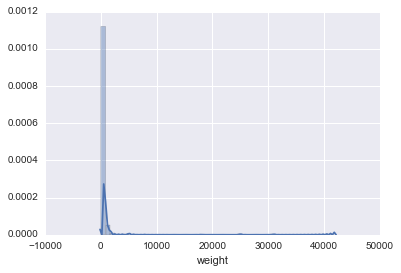

In [113]:
%matplotlib inline 
sns.distplot(products.weight.dropna())

distribution of pieces

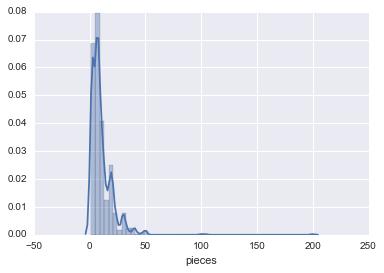

In [114]:
sns.distplot(products.pieces.dropna())

#### Lets clean up product names a bit, we have ~1000 unique names once we cleaned the weights, but there is much more work to be done
#### Products have some abbreviation leftovers that I did not clean, products have similar names but different word forms, etc.

In [115]:
products.short_name.nunique()

1014

Let's clean stop words and leave only the word stems (I did not clean abbreviations, sorry)

In [116]:
from nltk.corpus import stopwords
print(stopwords.words("spanish"))

[u'de', u'la', u'que', u'el', u'en', u'y', u'a', u'los', u'del', u'se', u'las', u'por', u'un', u'para', u'con', u'no', u'una', u'su', u'al', u'lo', u'como', u'm\xe1s', u'pero', u'sus', u'le', u'ya', u'o', u'este', u's\xed', u'porque', u'esta', u'entre', u'cuando', u'muy', u'sin', u'sobre', u'tambi\xe9n', u'me', u'hasta', u'hay', u'donde', u'quien', u'desde', u'todo', u'nos', u'durante', u'todos', u'uno', u'les', u'ni', u'contra', u'otros', u'ese', u'eso', u'ante', u'ellos', u'e', u'esto', u'm\xed', u'antes', u'algunos', u'qu\xe9', u'unos', u'yo', u'otro', u'otras', u'otra', u'\xe9l', u'tanto', u'esa', u'estos', u'mucho', u'quienes', u'nada', u'muchos', u'cual', u'poco', u'ella', u'estar', u'estas', u'algunas', u'algo', u'nosotros', u'mi', u'mis', u't\xfa', u'te', u'ti', u'tu', u'tus', u'ellas', u'nosotras', u'vosostros', u'vosostras', u'os', u'm\xedo', u'm\xeda', u'm\xedos', u'm\xedas', u'tuyo', u'tuya', u'tuyos', u'tuyas', u'suyo', u'suya', u'suyos', u'suyas', u'nuestro', u'nuestra', 

In [117]:
products['short_name_processed'] = (products['short_name']
                                        .map(lambda x: " ".join([i for i in x.lower()
                                                                 .split() if i not in stopwords.words("spanish")])))

In [118]:
products['short_name_processed'].nunique()

992

In [119]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("spanish")

In [120]:
print(stemmer.stem("Tortillas"))

tortill


In [121]:
products['short_name_processed'] = (products['short_name_processed']
                                        .map(lambda x: " ".join([stemmer.stem(i) for i in x.lower().split()])))

In [122]:
products.short_name_processed.nunique()

963

In [123]:
len(products.short_name_processed)

2592

In [124]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 1000) 

product_bag_words = vectorizer.fit_transform(products.short_name_processed).toarray()
product_bag_words.shape

(2592, 688)

In [125]:
product_bag_words = pd.concat([products.Producto_ID, 
                               pd.DataFrame(product_bag_words, 
                                            columns= vectorizer.get_feature_names(), index = products.index)], axis=1)
product_bag_words.head()

,Producto_ID,abc,abej,aceit,actifresh,agu,ajn,ajon,ajonj,ajonjoli,...,wb,wendys,whit,whol,wond,wonderbutt,yerbabuen,you,zarzamor,zer
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,41,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,53,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,72,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [127]:
product_bag_words.drop('Producto_ID', axis=1).sum().sort_values(ascending=False).head(100)

pan          220
fres         157
tost         115
duo          101
tub          100
vainill       94
delici        92
blanc         91
chocolat      91
gallet        84
gansit        80
barrit        77
tortill       76
suavicrem     69
nuez          63
multigran     63
frut          63
pin           61
lat           58
bran          57
mantec        56
boll          56
tortillin     55
princip       55
triki         51
mini          51
kc            50
integral      50
choc          49
medi          48
            ... 
mm            20
jamon         20
extra         19
azuc          19
pinguin       19
burrit        18
conch         18
chochit       18
ric           18
rock          18
bk            18
cuernit       17
canapin       17
reban         17
tir           16
bigot         16
panqu         16
escol         15
salv          15
sponch        15
fs            15
mari          15
chisp         15
bols          15
thins         14
dalmat        14
orejit        14
pastiset      

####  let's have a look, what is the product with the biggest demand of all times

In [132]:
df = (pd.merge(agg1.reset_index(), products, on='Producto_ID', how='left').
      groupby('short_name')['Demanda_uni_equil_sum'].sum().sort_values(ascending=False))

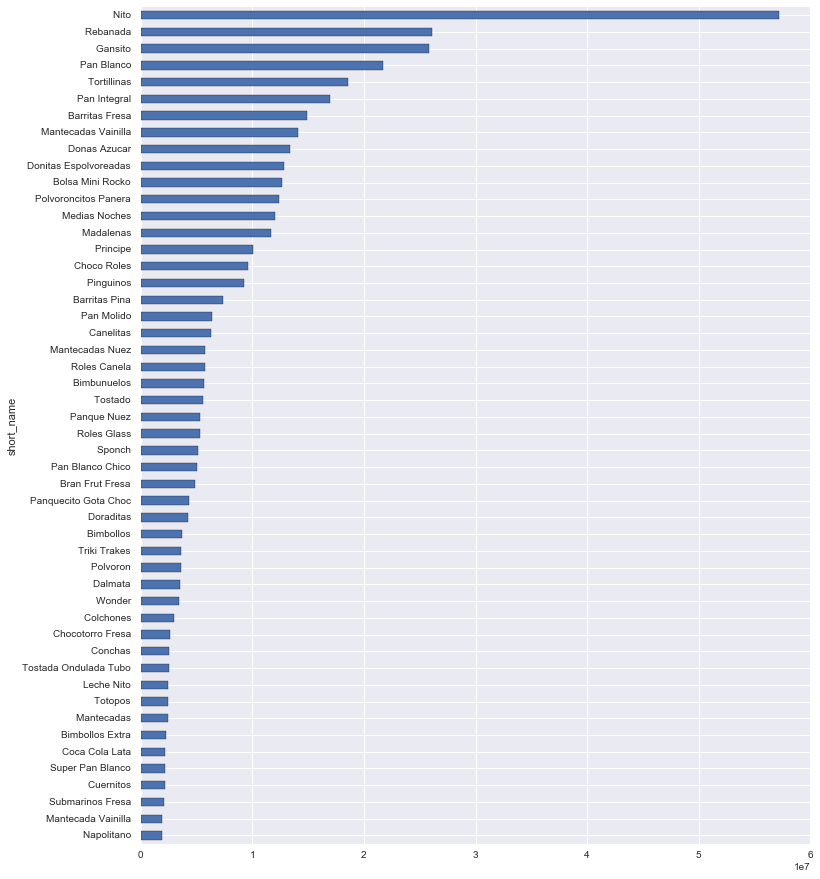

In [133]:
plt.figure(figsize = (12,15))
df.head(50).sort_values().plot(kind='barh')

In [134]:
df.head(5)

short_name
Nito            57205818
Rebanada        26098669
Gansito         25823976
Pan Blanco      21724162
Tortillinas     18550572
Name: Demanda_uni_equil_sum, dtype: int32

The best seller is by far Nito. Check this out, looks yummy : 

![](http://static.manufactura.mx/media/2013/11/20/negrito.jpg)

#### a quick look at the distributions

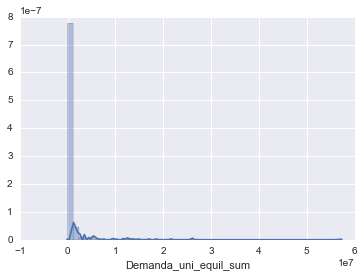

In [135]:
sns.distplot(df)

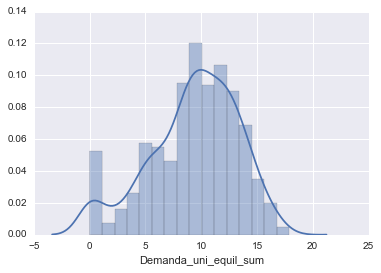

In [136]:
sns.distplot(np.log1p(df))

#### expanding the aggregate

In [137]:
df = (pd.merge(agg.reset_index(), products, on='Producto_ID', how='left').
      groupby('short_name')['Demanda_uni_equil_sum', 'Venta_uni_hoy_sum', 'Dev_uni_proxima_sum', 'Dev_uni_proxima_count']
      .sum().sort_values(by = 'Demanda_uni_equil_sum', ascending=False))

In [140]:
df.describe()

,Demanda_uni_equil_sum,Venta_uni_hoy_sum,Dev_uni_proxima_sum,Dev_uni_proxima_count
count,7.160000e+02,7.160000e+02,716.000000,7.160000e+02
mean,7.484937e+05,7.573622e+05,13495.215084,1.036040e+05
std,3.268453e+06,3.295051e+06,42786.288677,3.554669e+05
min,0.000000e+00,0.000000e+00,0.000000,1.000000e+00
25%,9.585000e+02,1.047500e+03,17.500000,4.575000e+01
50%,1.835250e+04,1.892700e+04,465.500000,9.540000e+02
75%,1.949022e+05,2.014155e+05,6409.500000,1.475900e+04
max,5.720582e+07,5.756934e+07,496495.000000,3.068521e+06


There are interesting things. There are products for which Demanda_uni_equil_sum = 0 and other fields are not equal to 0

In [141]:
df[df.Demanda_uni_equil_sum == 0].count()

Demanda_uni_equil_sum    32
Venta_uni_hoy_sum        32
Dev_uni_proxima_sum      32
Dev_uni_proxima_count    32
dtype: int64

In [142]:
df[df.Demanda_uni_equil_sum == 0]

,Demanda_uni_equil_sum,Venta_uni_hoy_sum,Dev_uni_proxima_sum,Dev_uni_proxima_count
short_name,,,,
Max Two Pack Elote Mango,0,0,7,1
Combo Tost Clas mas Frijol,0,0,47,2
Surtido,0,0,446,1
Two Pack Classicas AvellanaFsa,0,0,3,1
Mentho Plus Miel,0,200,623,3
Clasicas de Regalo Sabor Chocol,0,0,3,2
Orejas,0,0,10,7
Lata Butter,0,0,22,1
Pan Tost Silueta,0,0,5,1


Similarly there are products with 0 sales and only returns

In [144]:
df[df.Venta_uni_hoy_sum == 0]

,Demanda_uni_equil_sum,Venta_uni_hoy_sum,Dev_uni_proxima_sum,Dev_uni_proxima_count
short_name,,,,
Max Two Pack Elote Mango,0,0,7,1
Combo Tost Clas mas Frijol,0,0,47,2
Surtido,0,0,446,1
Two Pack Classicas AvellanaFsa,0,0,3,1
Clasicas de Regalo Sabor Chocol,0,0,3,2
Orejas,0,0,10,7
Lata Butter,0,0,22,1
Pan Tost Silueta,0,0,5,1
Galleta Confeti,0,0,13,3


there are products that were never returned

In [145]:
df[df.Dev_uni_proxima_sum == 0].count()

Demanda_uni_equil_sum    106
Venta_uni_hoy_sum        106
Dev_uni_proxima_sum      106
Dev_uni_proxima_count    106
dtype: int64

In [146]:
df[df.Dev_uni_proxima_sum == 0].head(20)

,Demanda_uni_equil_sum,Venta_uni_hoy_sum,Dev_uni_proxima_sum,Dev_uni_proxima_count
short_name,,,,
Bollos Quarter Pounder McD,39372,39372,0,920
Bollo Regular,31628,31628,0,917
Bollo Big Mac,22503,22503,0,914
Principe Mix,20540,20540,0,95
Sand Clasico Multigrano Cong,20162,20162,0,20
Mini Milk Chococat Valentines,17936,17936,0,181
Bollos Wendys,16952,16952,0,124
Bollo Angus McDonalds,16192,16192,0,7
Bollo Random Wendys,14961,14961,0,126


Let's cut products into 10 quantiles by summary adjusted demand.

In [151]:
df['Q'] = pd.qcut(df.Demanda_uni_equil_sum, 10)
df.Q.head()

short_name
Nito            (1283696, 57205818]
Rebanada        (1283696, 57205818]
Gansito         (1283696, 57205818]
Pan Blanco      (1283696, 57205818]
Tortillinas     (1283696, 57205818]
Name: Q, dtype: category
Categories (10, object): [[0, 49] < (49, 415] < (415, 2710.5] < (2710.5, 7664] ... (4.5e+04, 135612] < (135612, 336878] < (336878, 1283696] < (1283696, 57205818]]

In [148]:
df[df.Q == '[0, 49]'].index.values

array(['Bran Frut Mango ', 'Duo Plativolos ', 'Principe mas Navigalleta',
       'Pan Tostado Tradicional Indi ', 'Galleta Confeti Prueb ',
       'Duo Bran Fresa Pina ', 'Bran Frut con Avena ',
       'Lata Redonda Mixta Generico ', 'Mini Doraditas ',
       'Polvoron Individual ', 'Galleta Avena Chispas MG ',
       'Sandwichera Epix Futbol ', 'Besos de Nuez Cons',
       'Tarima Galletero Navideno ', 'Totopos Redondos ',
       'Exhibidor Sanissimo ', 'Duo Marias ', 'Pallet Canelitas Media KC ',
       'Spirrones ', 'Bolsita Teddy Bear ', 'Tubo Galleta Gansito MG ',
       'Tortilla Harina Casera ', 'Bubulubu Twin Pack ',
       'Barritas FresaPina Cj Exhib ', 'Lata Cuadrad Mix Navidad ',
       'Galleta Almenuez Bajio ', 'Donas ', 'Bombonete Temporalidad ',
       'Mini Gansito ', 'Mini Rocko Vitrolero ',
       'Sand Clasico Dob Fibra Det ', 'Mini Gansito Pack ',
       'Deliciosas Chocolate ', 'Leche Nito Chocolate ',
       'Molido Industrial ', 'Lata Corazon Colores Besos Nuez 

distribution of returns by product

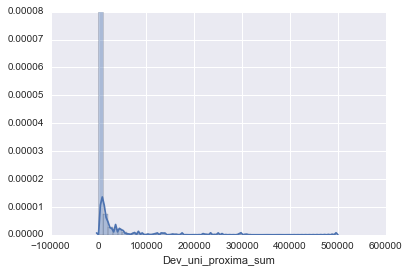

In [152]:
sns.distplot(df.Dev_uni_proxima_sum)

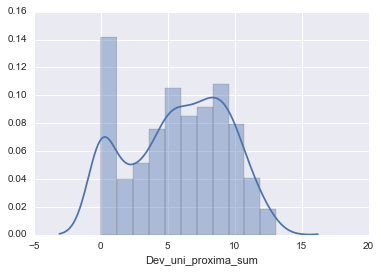

In [153]:
sns.distplot(np.log1p(df.Dev_uni_proxima_sum))

Distribution of counts by product

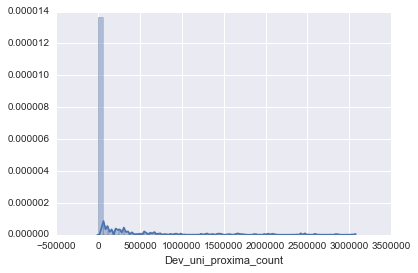

In [154]:
sns.distplot(df.Dev_uni_proxima_count)

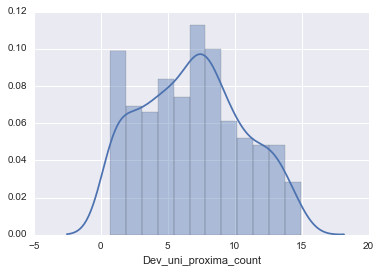

In [155]:
sns.distplot(np.log1p(df.Dev_uni_proxima_count))

#### lets aggregate by week and short_name now

In [156]:
df_hmp = (pd.merge(agg.reset_index(), products, on='Producto_ID', how='left').
      groupby(['Semana','short_name'])['Demanda_uni_equil_sum', 'Venta_uni_hoy_sum', 'Dev_uni_proxima_sum', 'Dev_uni_proxima_count'].sum().reset_index())

In [162]:
df_hmp.head()

,Semana,short_name,Demanda_uni_equil_sum,Venta_uni_hoy_sum,Dev_uni_proxima_sum,Dev_uni_proxima_count,log1p_Demanda_uni_equil_sum
0,3,,26952,27249,431,818,10.201850
1,3,ActiFresh Menta,4140,4511,466,60,8.328693
2,3,ActiFresh Yerbabuena,3821,4120,489,60,8.248529
3,3,Agua Ciel Jamaica,5838,5962,137,205,8.672315
4,3,Agua Ciel Limon,5752,5943,207,200,8.657477


#### a quick check if demand distribution changes week to week

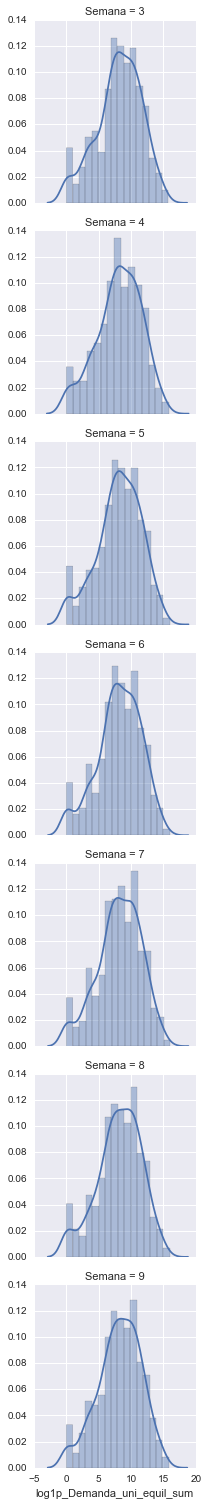

In [164]:
df_hmp['log1p_Demanda_uni_equil_sum'] = np.log1p(df_hmp.Demanda_uni_equil_sum)
g = sns.FacetGrid(df_hmp, row = 'Semana')
g = g.map(sns.distplot, 'log1p_Demanda_uni_equil_sum')

#### Now let's look at which proucts sell by week with interactive heatmaps. Let's use our quantiles here.

In [165]:
from bokeh.charts import HeatMap
from bokeh.plotting import vplot

heatmaps = []
for i in df.Q.cat.categories.values:
    hm = HeatMap(df_hmp[df_hmp.short_name.isin(df[df.Q == i].index.values)],
                        x='short_name', y = 'Semana', values = 'Demanda_uni_equil_sum',
                 hover_tool = True, title = 'Products with summary demand '+ str(i), xgrid = False,
                 stat = 'sum',plot_width=950, plot_height=400, tools='hover, box_zoom, resize, save, wheel_zoom, reset',
                 )
    heatmaps.append(hm)
show(vplot(*heatmaps))

#### Same series of charts but for returns

In [166]:
from bokeh.charts import HeatMap
from bokeh.plotting import vplot
df['Q_ret'] = pd.qcut(df.Dev_uni_proxima_sum, 5)
heatmaps = []
for i in df.Q_ret.cat.categories.values:
    hm = HeatMap(df_hmp[df_hmp.short_name.isin(df[df.Q_ret == i].index.values)],
                        x='short_name', y = 'Semana', values = 'Demanda_uni_equil_sum',
                 hover_tool = True, title = 'Products with summary returns '+ str(i), xgrid = False,
                 stat = 'sum',plot_width=800, plot_height=400, tools='hover, box_zoom, resize, save, wheel_zoom, reset',
                 )
    heatmaps.append(hm)
show(vplot(*heatmaps))